In [1]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

### Static Variables

In [2]:
line = "15"

### Reading Data

In [3]:
df = pd.read_csv("bus_data/line_data/" + line + ".csv", low_memory=False, header=None)
df.columns = ["Timestamp", "LineID", "JourneyPatternID", "TimeFrame", 
              "VehicleJourneyID", "Lon", "Lat", "VehicleID", "StopID", 
              "AtStop", "HumanTime", "Day", "Hour", "Runtime"]

#convert StopID to string

df['StopID'] = df['StopID'].astype('str')


df.head()

,Timestamp,LineID,JourneyPatternID,TimeFrame,VehicleJourneyID,Lon,Lat,VehicleID,StopID,AtStop,HumanTime,Day,Hour,Runtime
0,1352181644000000,15,1,2012-11-06,5891,-6.153783,53.402687,33553,6319,1,2012-11-06 06:00:44,1,6,0
1,1352181825000000,15,1,2012-11-06,5891,-6.163521,53.399288,33553,4594,1,2012-11-06 06:03:45,1,6,181
2,1352181904000000,15,1,2012-11-06,5891,-6.173066,53.402138,33553,4595,1,2012-11-06 06:05:04,1,6,260
3,1352181908000000,15,1001,2012-11-06,5781,-6.310957,53.286865,33469,1153,1,2012-11-06 06:05:08,1,6,0
4,1352181944000000,15,1,2012-11-06,5891,-6.177130,53.402370,33553,4596,1,2012-11-06 06:05:44,1,6,300


### Getting Stop Locations

In [4]:
# # Isolating variations - getting variation with most stops

patterns = df['JourneyPatternID'].unique()

for pattern in patterns:
    print(pattern)

1
1001
1002
2


In [5]:
# Concat location data

df['location'] = ""
df['location'] = df['Lon'].astype(str) + "_" + df['Lat'].astype(str)

In [6]:
# Getting biggest pattern

max_pattern = df['JourneyPatternID'].value_counts().idxmax()
new_df = df[df.JourneyPatternID == max_pattern]

In [7]:
# cutting stops that don't appear more than 20 times

groups = new_df.groupby('StopID')
new_df = groups.filter(lambda x: len(x) > 20)


In [8]:
new_df.head()

,Timestamp,LineID,JourneyPatternID,TimeFrame,VehicleJourneyID,Lon,Lat,VehicleID,StopID,AtStop,HumanTime,Day,Hour,Runtime,location
0,1352181644000000,15,1,2012-11-06,5891,-6.153783,53.402687,33553,6319,1,2012-11-06 06:00:44,1,6,0,-6.153783_53.402687
1,1352181825000000,15,1,2012-11-06,5891,-6.163521,53.399288,33553,4594,1,2012-11-06 06:03:45,1,6,181,-6.163521_53.399288
2,1352181904000000,15,1,2012-11-06,5891,-6.173066,53.402138,33553,4595,1,2012-11-06 06:05:04,1,6,260,-6.173066_53.402138
4,1352181944000000,15,1,2012-11-06,5891,-6.177130,53.402370,33553,4596,1,2012-11-06 06:05:44,1,6,300,-6.17713_53.40237
5,1352182003000000,15,1,2012-11-06,5891,-6.181091,53.401699,33553,4563,1,2012-11-06 06:06:43,1,6,359,-6.181091_53.401699


In [9]:
groups = new_df.groupby('StopID')

In [10]:
# Extracting the most frequent locations for each stop
loc_df = groups['location'].agg(lambda x:x.value_counts().index[0]).to_frame()
loc_df.reset_index(level=0, inplace=True)

# Converting location back to float columns
loc_df['Lon'], loc_df['Lat'] = loc_df['location'].str.split('_', 1).str
loc_df['Lon'], loc_df['Lat'] = loc_df['Lon'].astype('float64'), loc_df['Lat'].astype('float64')

# drop concatenated colum 'location'
loc_df = loc_df.drop('location', axis=1)
loc_df.head()

,StopID,Lon,Lat
0,1014,-6.257341,53.335674
1,1015,-6.259940,53.332787
2,1016,-6.264520,53.331100
3,1017,-6.264435,53.329388
4,1018,-6.264751,53.327587


### Cleaned location data vs raw location data

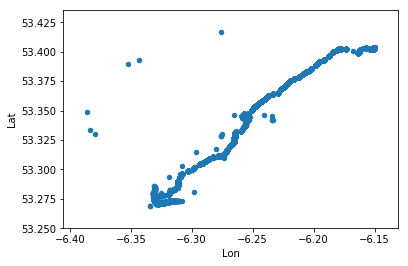

In [11]:
# Raw

locations = new_df[["Lon", "Lat"]]
locations.plot.scatter(x="Lon", y="Lat")

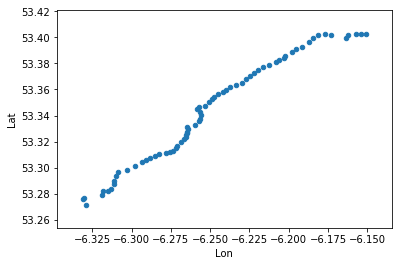

In [12]:
# Clean

locations = loc_df[["Lon", "Lat"]]
locations.plot.scatter(x="Lon", y="Lat")

### Getting Stop Orders

In [13]:
runtimes = new_df.groupby("StopID").Runtime.mean()

order = runtimes.sort_values().to_frame()
order.reset_index(level=0, inplace=True)
order['Order'] = order.index

### Merging dataframes and saving results

In [14]:
# adding LineID and JourneyPatternID

line_df = df[["LineID", "JourneyPatternID", "StopID"]]
line_df = line_df.drop_duplicates()
line_df.shape

(231, 3)

In [16]:
static_stops = pd.merge(order, line_df, on='StopID')
static_stops.shape

(113, 5)

In [17]:
static_stops = pd.merge(static_stops, loc_df, on="StopID" )

In [19]:
static_stops[static_stops.JourneyPatternID == 1].head(100)

,StopID,Runtime,Order,LineID,JourneyPatternID,Lon,Lat
0,6318,0.522727,0,15,1,-6.150800,53.402317
3,6319,176.605505,1,15,1,-6.153783,53.402687
6,7246,211.983939,2,15,1,-6.157236,53.402843
9,6320,273.739336,3,15,1,-6.162333,53.401539
11,4594,340.451743,4,15,1,-6.163521,53.399288
13,4595,451.524666,5,15,1,-6.173066,53.402138
15,4596,502.232877,6,15,1,-6.177130,53.402370
17,4563,523.005954,7,15,1,-6.181091,53.401699
19,1218,645.138390,8,15,1,-6.184258,53.399723
21,1270,680.505449,9,15,1,-6.187183,53.396484


In [ ]:
# static_stops.to_csv('bus_data/static_data/routestops' + line + '.csv')

In [ ]:
static_stops.head()